In [1]:
import matplotlib.pyplot as plt
import sys
from os import path
sys.path.append(path.dirname(path.dirname(path.abspath('model.py'))))

In [2]:
from torch import load, save
from importlib import reload

In [136]:
import model
reload(model);

# Load training data

In [100]:
# Load train data
TRAIN_PATH = '../../data/train_data.pkl'
train_noisy_imgs_input, train_noisy_imgs_target = load(TRAIN_PATH)
train_noisy_imgs_input = train_noisy_imgs_input/255
train_noisy_imgs_target = train_noisy_imgs_target/255
print('training size: ', train_noisy_imgs_input.shape[0])
training_set_size, num_channels, y_size, x_size = train_noisy_imgs_input.shape

training size:  50000


In [79]:
# Load validation data
VALIDATION_PATH = '../../data/val_data.pkl'
validation_noisy_imgs, validation_clean_imgs = load(VALIDATION_PATH)
validation_noisy_imgs = validation_noisy_imgs/255
validation_clean_imgs = validation_clean_imgs/255
print('validation size: ', validation_clean_imgs.shape[0])

validation size:  1000


## Our implementation

In [137]:
ourModel = model.Model()
ourModel.train(train_noisy_imgs_input, train_noisy_imgs_target, num_epochs=1)

Doing epoch 0
0.08221927136182786
0.07549952417612076
0.07377561330795288
0.07860396951436996
0.07031712979078293
0.07452671229839325
0.07603704929351807
0.07380822151899338
0.07235501259565354
0.07564290314912796
0.07104064226150512
0.07407818138599395
0.07341857850551606
0.07561296820640565
0.07646855860948562
0.07402746826410293
0.07230755239725113
0.07527289539575577
0.07133079022169113
0.0763858512043953
0.07738514542579651
0.07495411336421967
0.07650917768478394
0.07614275962114334
0.07488030195236206
0.07394779026508332
0.07588259726762772
0.07286733686923981
0.06966909617185593
0.0774703249335289
0.07956361919641494


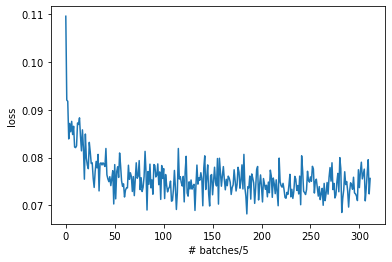

In [177]:
fig = plt.figure()
plt.plot(ourModel.losses)
plt.xlabel('# batches/5')
plt.ylabel('loss')
plt.show()

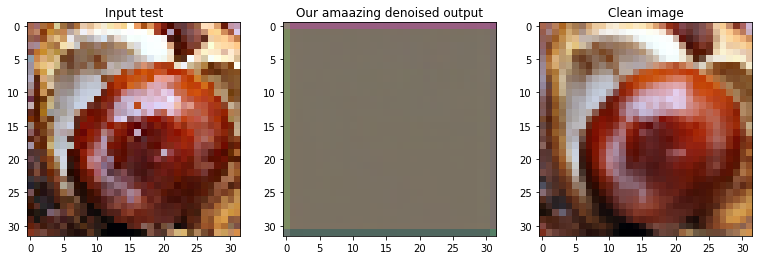

In [139]:
test_input = validation_noisy_imgs
test_target = validation_clean_imgs

nr = 3
denoised = ourModel.predict(test_input[nr, :, :, :].unsqueeze(dim=0))

fig, ax = plt.subplots(1, 3, figsize=(13,5))
ax[0].imshow(test_input[nr,:,:,:].permute(1,2,0).cpu(), cmap='gray')
ax[0].set_title('Input test')
ax[1].imshow(denoised[0,:,:,:].permute(1,2,0).cpu().detach().numpy(), cmap='gray')
ax[1].set_title('Our amaazing denoised output')
ax[2].imshow(test_target[nr, :, :, :].permute(1,2,0).cpu(), cmap='gray')
ax[2].set_title('Clean image')
plt.show()

In [235]:
def evaluate(denoised, target):
    mse = torch.mean((denoised - target) ** 2)
    return -10 * torch.log10(mse + 10**-8)

In [17]:
save(ourModel.model, 'bestmodel.pt')

'bestmodel.pt)' was not found in history, as a file, url, nor in the user namespace.


## Torch implementation

In [142]:
import torch
import torch.nn as nn

In [275]:
torch.set_grad_enabled(True)
torch_model = nn.Sequential(nn.Conv2d(3, 16, 3, stride=2, padding=1),
              nn.ReLU(),
              nn.Conv2d(16, 32, 3, stride=2, padding=1),
              nn.ReLU(),
              nn.Upsample(scale_factor=2),
              nn.Conv2d(32, 16, 3, padding=1),
              nn.ReLU(),
              nn.Upsample(scale_factor=2),
              nn.Conv2d(16, 3, 3, padding=1),
            #   nn.Sigmoid()
              )

# optimizer = torch.optim.SGD(torch_model.parameters(), lr = 1e-3)
optimizer = torch.optim.Adam(torch_model.parameters())
criterion = nn.MSELoss()

In [258]:
summary(torch_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             448
              ReLU-2           [-1, 16, 16, 16]               0
            Conv2d-3             [-1, 32, 8, 8]           4,640
              ReLU-4             [-1, 32, 8, 8]               0
          Upsample-5           [-1, 32, 16, 16]               0
            Conv2d-6           [-1, 16, 16, 16]           4,624
              ReLU-7           [-1, 16, 16, 16]               0
          Upsample-8           [-1, 16, 32, 32]               0
            Conv2d-9            [-1, 3, 32, 32]             435
          Sigmoid-10            [-1, 3, 32, 32]               0
Total params: 10,147
Trainable params: 10,147
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.39
Params size (MB): 0.04
Estimated Tot

In [276]:
train_input = train_noisy_imgs_input
train_target = train_noisy_imgs_target
batch_size = 32
num_epochs = 1
avg_loss = 0
losses = []

for e in range(num_epochs):
    print('Doing epoch %d'%e)
    for b, (input, target) in enumerate(zip(train_input.split(batch_size),
                                            train_target.split(batch_size))):
        output = torch_model(input)
        loss = criterion(output, target)
        avg_loss += loss.item()

        # make step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        b_freq = 5
        if b % b_freq == 0 and (b+e) > 0:
            losses.append(avg_loss / b_freq)
            avg_loss = 0
            b % 50 == 0 and print(losses[-1])

Doing epoch 0
0.041433773934841156
0.027401167526841165
0.02276640646159649
0.02177879512310028
0.017695849016308784


KeyboardInterrupt: 

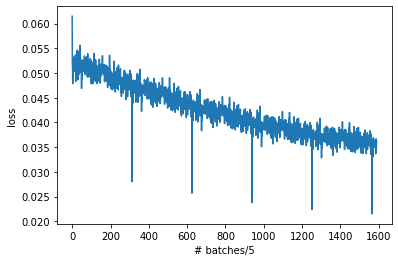

In [210]:
fig = plt.figure()
plt.plot(losses)
plt.xlabel('# batches/5')
plt.ylabel('loss')
plt.show()

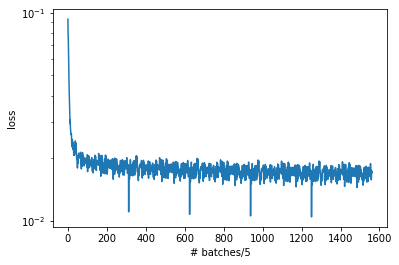

In [272]:
fig = plt.figure()
plt.plot(losses)
plt.yscale('log')
plt.xlabel('# batches/5')
plt.ylabel('loss')
plt.show()

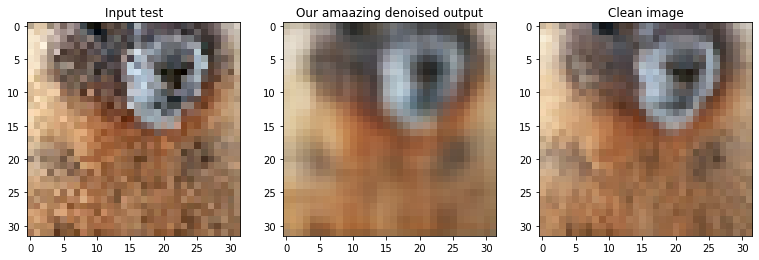

In [273]:
test_input = validation_noisy_imgs
test_target = validation_clean_imgs

nr = 1
denoised = torch_model(test_input[nr, :, :, :].unsqueeze(dim=0))

fig, ax = plt.subplots(1, 3, figsize=(13,5))
ax[0].imshow(test_input[nr,:,:,:].permute(1,2,0).cpu(), cmap='gray')
ax[0].set_title('Input test')
ax[1].imshow(denoised[0,:,:,:].permute(1,2,0).cpu().detach().numpy(), cmap='gray')
ax[1].set_title('Our amaazing denoised output')
ax[2].imshow(test_target[nr,:,:,:].permute(1,2,0).cpu(), cmap='gray')
ax[2].set_title('Clean image')
plt.show()

In [274]:
evaluate(denoised, test_target)

tensor(10.5982, grad_fn=<MulBackward0>)